Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/mis-ai-accelerator/raw/main/notebook.ipynb">
      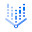
      Run in Vertex AI Workbench
    </a>
    </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/mis-ai-accelerator/blob/main/notebook.ipynb">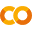
    Run in Colab
    </a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/mis-ai-accelerator/">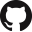
    View on GitHub
    </a>
  </td>
</table>

# Google Cloud Medical Imaging ML Development Accelerators

Once you have labeled datasets we will ingest them in Healthcare API, use BigQuery to filter the cohorts of information, retrieve the relevant labeled images, train using the CXR foundational model, and ultimately test our trained model on staged data.

## Setup

We'll perform some configuration, initialize a few constants, and install some packages here. These will be used by the rest of the notebook.

### Prerequisites

- You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.
- Code was tested with Python v3.10.6 in VSCode, Vertex AI Workbench, and Colab

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import random
import sys

# Consts for your GCP environment
PROJECT_ID          = '[CHANGEME]' #@param {type: 'string'}
LOCATION            = 'us-central1' #@param {type: 'string'}
DATASET_ID          = f'dataset_{random.randint(1,1000)}'
STORE_ID            = 'store_id' #@param {type: 'string'}
DICOMWEB_HOST       = f'https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/datasets/{DATASET_ID}/dicomStores/{STORE_ID}/dicomWeb'
BQ_TABLE_ID         = 'metadata' #@param {type: 'string'}
BQ_TABLE            = f'{PROJECT_ID}.{DATASET_ID}.{BQ_TABLE_ID}'

# Other Consts
DIAGNOSIS           = 'PNEUMOTHORAX'
STAGED_DIR          = './data/staged/'
STAGED_DICOM_DIR    = './data/staged/inputs/'
DICOM_DIR           = './data/inputs'
EMBEDDINGS_DIR      = './data/outputs'
MODEL_DIR           = './data/outputs/model'
MIN_STUDIES         = 195

# Remove if you don't want this level of logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Authenticate; will only run if you're in Colab
if 'google.colab' in sys.modules:
    from google.colab import auth
    # Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
    auth.authenticate_user()

# Some basic input validation
if PROJECT_ID == '[CHANGEME]':
  raise ValueError('Please provide your own value for PROJECT_ID')

In [ ]:
%%bash

# Needed packages for BQ and DICOMweb
pip install db-dtypes dicomweb-client[gcp]

# Model training dependencies
pip install scikit-learn tf-models-official>=2.13.0

# Package for CXR foundation model wrapper
CXR_COMMIT='6c284364e3883353ed737545e475a1016620fd7e' # tested version locked
CXR_URL=https://github.com/Google-Health/imaging-research/archive/${CXR_COMMIT}.zip
if ! test -d imaging-research-${CXR_COMMIT}; then
    curl -L -o imaging-research-${CXR_COMMIT}.zip ${CXR_URL}
    unzip -o imaging-research-${CXR_COMMIT}.zip
    pip install imaging-research-${CXR_COMMIT}/cxr-foundation/
    rm -rf imaging-research-${CXR_COMMIT}.zip
fi

### GCP resource setup

Use Terraform to set up a [Healthcare API DICOM store](https://cloud.google.com/healthcare-api/docs/how-tos/dicom#creating_a_dicom_store), [BigQuery table](https://cloud.google.com/bigquery/docs/tables), and [streaming](https://cloud.google.com/healthcare-api/docs/how-tos/dicom-bigquery-streaming) of metadata from Healthcare API DICOM store to a BigQuery table.

**NOTE:** You must grant the role(s) bigquery.dataEditor role to your project's Cloud Healthcare Service Agent, in order to have metadata streamed from Healthcare API DICOM store to BigQuery.

In [ ]:
%%bash

# Retrieve staged data and scripts
if ! test -d data || ! test -d tf; then
    gsutil -m cp -r gs://mis-ai-accelerator/* .
fi

In [ ]:
%%bash

# Retrieve terraform executable locally
TF_URL=https://releases.hashicorp.com/terraform/1.6.1/terraform_1.6.1_linux_amd64.zip
if ! test -f terraform; then
    curl -so terraform.zip ${TF_URL}
    unzip terraform.zip
    rm -rf terraform.zip
fi

In [ ]:
# Deploy terraform
!./terraform -chdir=./tf init
!./terraform -chdir=./tf plan -var="project_id={PROJECT_ID}" -var="location={LOCATION}" -var="dataset_id={DATASET_ID}" -var="store_id={STORE_ID}" -var="table_id={BQ_TABLE_ID}" -out tf.plan 
!./terraform -chdir=./tf apply tf.plan
# TODO[JK]: If this step fails, stop execution

In [ ]:
%%bash
STATUS_CODE=$(curl --write-out %{http_code} --silent --output /dev/null metadata)
if [[ "${STATUS_CODE}" -eq 200 ]]; then
    # Set MIS label on current GCE instance
    VMNAME=$(curl -H Metadata-Flavor:Google metadata/computeMetadata/v1/instance/hostname | cut -d. -f1)
    ZONE=$(curl -H Metadata-Flavor:Google metadata/computeMetadata/v1/instance/zone | cut -d/ -f4)
    gcloud compute instances update ${VMNAME} --zone=${ZONE} --update-labels=goog-packaged-solution=medical-imaging-suite
    echo Set label on ${VMNAME}
else
    echo Skipping label since we\'re not inside a GCE instance.
fi

### Healthcare API and BigQuery client setup


In [ ]:
from dicomweb_client.api import DICOMwebClient
from dicomweb_client.ext.gcp.session_utils import create_session_from_gcp_credentials
from dicomweb_client.ext.gcp.uri import GoogleCloudHealthcareURL

import os
from google.cloud import bigquery

# Initialize our DICOMweb client to Healthcare API
dicomweb_client = DICOMwebClient(
    url=str(GoogleCloudHealthcareURL.from_string(DICOMWEB_HOST)),
    session=create_session_from_gcp_credentials(),
)

# Initialize our BigQuery client (need project ID for Colab)
bq_client = bigquery.Client(project=PROJECT_ID)

## Prepare DICOM Instances

Start by sending all positive and negative Pneumothorax datasets to the Healthcare API DICOM endpoint. There should be 200 studies in all (100 positive and 100 negative).

### [Option 1] Send bulk studies from PACS to the Healthcare API DICOM Store

If you're sending data from PACS, then the way in which you ingest the data will depend on the particular product you're using. If unsure, please reach out to the vendor for support. If your PACS only supports DIMSE based send, then you'll likely benefit from setting up a [DICOM adapter](https://github.com/GoogleCloudPlatform/healthcare-dicom-dicomweb-adapter).


### [Option 2] Send bulk studies from local staged content to the Healthcare API DICOM Store

If you prefer sending the local staged content, then you can leverage the following code:


In [ ]:
import glob
import pydicom

datasets = list(
    map(lambda file: pydicom.dcmread(file), glob.glob(STAGED_DICOM_DIR + "*.dcm"))
)
dicomweb_client.store_instances(datasets=datasets)

# Send a minimum amount of studies to use on top of foundational model
if len(datasets) < MIN_STUDIES:
    raise ValueError(f"Please send the minimum amount of studies: {MIN_STUDIES}")

print("Sent {0} DICOM instances".format(len(datasets)))

### Map DICOM instances with labels, using BigQuery

Execute a query against BQ to get the list of DICOM instances that are positive and negative for Pneumothorax, based on presence of KOS.

**NOTE:** If you've just recently pushed a bunch of images to the Healthcare API DICOM Store, then it might take a few seconds to propagate the metadata to BigQuery.


In [ ]:
#   DICOM types
#   Key Object Selection Document, SOPClassUID=1.2.840.10008.5.1.4.1.1.88.59, Modality=KO
#   Secondary Capture Image Storage, SOPClassUID=1.2.840.10008.5.1.4.1.1.7, Modality=DX

query = """
SELECT
  StudyInstanceUID,
  SeriesInstanceUID,
  SOPInstanceUID,
  CAST (CAST (StudyInstanceUID IN (
      SELECT
        DISTINCT StudyInstanceUID
      FROM
        `{}`
      WHERE
        SOPClassUID='1.2.840.10008.5.1.4.1.1.88.59'
        AND Modality='KO') AS INT64) AS FLOAT64) AS {}
FROM
  `{}`
WHERE
  SOPClassUID='1.2.840.10008.5.1.4.1.1.7'
  AND Modality='DX'
""".format(
    BQ_TABLE, DIAGNOSIS, BQ_TABLE
)

bq_job_config = bigquery.QueryJobConfig(use_query_cache=False)
bq_df = bq_client.query(query, bq_job_config).to_dataframe()

# Waiting for BQ to be populated with enough metadata
if len(bq_df) < MIN_STUDIES:
    raise ValueError(
        f"Re-run this cell until BQ has been populated the minimum amount of metadata: {len(bq_df)}/{MIN_STUDIES}"
    )

# Paths to download DICOM files
bq_df["dicom_file"] = bq_df["SOPInstanceUID"].apply(
    lambda x: os.path.join(DICOM_DIR, x + ".dcm")
)
# Paths for generated embeddings
bq_df["embedding_file"] = bq_df["dicom_file"].apply(
    lambda x: os.path.join(
        EMBEDDINGS_DIR, os.path.basename(x).replace(".dcm", ".tfrecord")
    )
)

display(bq_df.tail())

### Retrieve mapped DICOM files locally for training

Use the DataFrame constructed in the previous BigQuery cell and retrieve the files locally from the Healthcare API DICOM store. These files will be used to generate the embeddings used in the training pipeline.


In [ ]:
if not os.path.exists(DICOM_DIR):
    os.makedirs(DICOM_DIR)

for _, row in bq_df.iterrows():
    instance = dicomweb_client.retrieve_instance(
        study_instance_uid=row["StudyInstanceUID"],
        series_instance_uid=row["SeriesInstanceUID"],
        sop_instance_uid=row["SOPInstanceUID"],
    )
    instance.save_as(row["dicom_file"])

if len(bq_df) < MIN_STUDIES:
    raise ValueError(
        f"Please locally download the minimum amount of studies: {len(bq_df)}/{MIN_STUDIES}"
    )

print("Downloaded {0} DICOM images".format(len(bq_df)))

## Generate Embeddings

**IMPORTANT:** You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

This will request the embeddings from the Vertex AI endpoint for the CXR foundational model and may take ~15 minutes depending on the load on the server and your connection speed. You may think of embeddings as compressed raster images, in a format efficient for model training.

_There may be some warnings about "Could not load dynamic library" and or "No project ID could be determined," but these can be safely ignored._


In [ ]:
from cxr_foundation.inference import generate_embeddings, InputFileType, OutputFileType

if not os.path.exists(EMBEDDINGS_DIR):
    os.makedirs(EMBEDDINGS_DIR)

generate_embeddings(
    input_files=bq_df["dicom_file"].values,
    output_dir=EMBEDDINGS_DIR,
    input_type=InputFileType.DICOM,
    output_type=OutputFileType.TFRECORD,
)

### Prepare Data for Model Training

Separate into training, validation, and testing sets.


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_validate = train_test_split(bq_df, test_size=0.1)

## Train A Model

Finally, we can train a model using the embeddings! With a simple feed-forward neural network, it should take < 5 minutes to train 100 epochs! No GPU required.


In [ ]:
import tensorflow as tf
import tensorflow_models as tfm
from cxr_foundation import embeddings_data


def create_model(
    heads,
    embeddings_size=1376,
    learning_rate=0.1,
    end_lr_factor=1.0,
    dropout=0.0,
    decay_steps=1000,
    loss_weights=None,
    hidden_layer_sizes=[512, 256],
    weight_decay=0.0,
    seed=None,
) -> tf.keras.Model:
    # Creates linear probe or multilayer perceptron using LARS + cosine decay.
    inputs = tf.keras.Input(shape=(embeddings_size,))
    hidden = inputs
    # If no hidden_layer_sizes are provided, model will be a linear probe.
    for size in hidden_layer_sizes:
        hidden = tf.keras.layers.Dense(
            size,
            activation="relu",
            kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
            kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
            bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        )(hidden)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
    output = tf.keras.layers.Dense(
        units=len(heads),
        activation="sigmoid",
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
    )(hidden)

    outputs = {}
    for i, head in enumerate(heads):
        outputs[head] = tf.keras.layers.Lambda(
            lambda x: x[..., i : i + 1], name=head.lower()
        )(output)

    model = tf.keras.Model(inputs, outputs)
    learning_rate_fn = tf.keras.experimental.CosineDecay(
        tf.cast(learning_rate, tf.float32),
        tf.cast(decay_steps, tf.float32),
        alpha=tf.cast(end_lr_factor, tf.float32),
    )
    model.compile(
        optimizer=tfm.optimization.lars.LARS(learning_rate=learning_rate_fn),
        loss=dict([(head, "binary_crossentropy") for head in heads]),
        loss_weights=loss_weights or dict([(head, 1.0) for head in heads]),
        weighted_metrics=[
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        ],
    )
    return model


# Create training and validation Datasets
training_data = embeddings_data.get_dataset(
    filenames=df_train["embedding_file"].values, labels=df_train[DIAGNOSIS].values
)


validation_data = embeddings_data.get_dataset(
    filenames=df_validate["embedding_file"].values, labels=df_validate[DIAGNOSIS].values
)

# Create and train the model
model = create_model([DIAGNOSIS])

model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=100,
)

# Summary after training is complete
model.summary()

## Run prediction on local images

Load some images that the model has not seen before and test them locally.


In [ ]:
import numpy as np
from cxr_foundation import constants
from typing import Sequence
from cxr_foundation.inference import (
    create_example_from_image,
    _embedding_from_service,
    InputFileType,
)


# TODO[JK]: Promote this code to cxr-foundation
def embedding_and_model_predict(
    image_file: str, model: tf.keras.Model
) -> Sequence[float]:
    example = create_example_from_image(image_file, InputFileType.DICOM)
    embedding = _embedding_from_service(
        example,
        constants._EMBEDDINGS_PROJECT_NAME,
        constants._LOCATION,
        constants._ENDPOINT_ID,
    )
    return model.predict(np.array(embedding[0]))


for file in [STAGED_DIR + "positive.dcm", STAGED_DIR + "negative.dcm"]:
    result = embedding_and_model_predict(file, model)
    print("File: {0}, result: {1}".format(file, result))

## Cleanup resources


In [ ]:
# TODO: Uncomment to destroy resources (default=OFF for Run All)
# !./terraform -chdir=./tf destroy -auto-approve